In [2]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from scipy import signal
%matplotlib inline

# If you want a style choose one
plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'


df = pd.read_csv('data\da_prices\GUI_ENERGY_PRICES_202412312300-202512312300_UTC.csv')
df.head()

,MTU (CET/CEST),Area,Sequence,Day-ahead Price (EUR/MWh),MTU (CET/CEST) Start,MTU (CET/CEST) End,SummerIndicator,MTU (CET/CEST) End UTC
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,BZN|DE-LU,Sequence Sequence 1,2.16,01/01/2025 00:00:00,2025-01-01T00:15,CET,2024-12-31T23:15
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,BZN|DE-LU,Sequence Sequence 1,2.16,01/01/2025 00:15:00,2025-01-01T00:30,CET,2024-12-31T23:30
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,BZN|DE-LU,Sequence Sequence 1,2.16,01/01/2025 00:30:00,2025-01-01T00:45,CET,2024-12-31T23:45
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,BZN|DE-LU,Sequence Sequence 1,2.16,01/01/2025 00:45:00,2025-01-01T01:00,CET,2025-01-01T00:00
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,BZN|DE-LU,Sequence Sequence 1,1.60,01/01/2025 01:00:00,2025-01-01T01:15,CET,2025-01-01T00:15


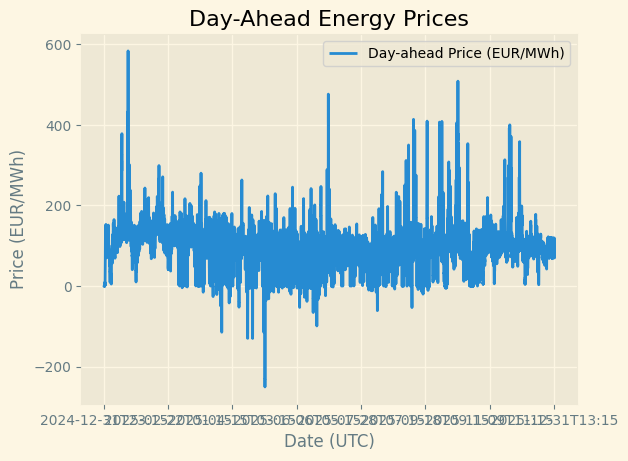

In [3]:
plot = df.plot(x='MTU (CET/CEST) End UTC', y='Day-ahead Price (EUR/MWh)', title='Day-Ahead Energy Prices', ylabel='Price (EUR/MWh)', xlabel='Date (UTC)')
plot.figure.savefig('day_ahead_energy_prices.png')

In [4]:
def plot_ts(ts = None, ts_add = None, title ='Time Series', legend=['1']):
    """
    Plots one or two time series in a single plot
    
        Args:
        ts: 1d- or 2d-array of time series. Dimension
            must be (n,) or (n,2)
        title: Title for the time plot.
        legend: list of legend names. If empty no legend.
        
        Returns:
        matplotlib plot object
    """
    plt.figure(figsize=(10, 4))
    plt.plot(ts, color=NF_ORANGE)
    plt.grid(True,axis='y')
    plt.title(title)
    if ts_add is not None:
        plt.plot(ts_add, color=NF_BLUE)
    if len(legend) > 0:
        plt.legend(legend)
    plt.show()

def plot_acf_pacf(ts, lags=10, layout='h'):
    """
    Plots the empirical ACF and PACF of a time series process.
    
        Args:
        ts: array of time series
        
        Returns:
        matplotlib subplot with ACF and PACF
    """
    if layout == 'h':
        fig, ax = plt.subplots(1, 2, figsize = (10,3))
    else: 
        fig, ax = plt.subplots(2, 1, figsize = (10,3))
    sm.tsa.graphics.plot_acf(ts,color = NF_ORANGE,lags=lags, ax = ax[0])
    sm.tsa.graphics.plot_pacf(ts,color = NF_ORANGE, lags = lags, ax = ax[1])    


def diff_series(ts, interval=1):
    """
    Differences a time series by a certain lag.
    
        Args:
        ts: array of 1d time series
        
        Returns:
        Differenced time series
    """
    diff = ts[interval:] - ts[:-interval]
    return diff

def kpss_test(ts):
    """
    Performs a KPSS test for the null hypothesis of stationarity.
    
        Args:
        ts: 1d time series
        
        Returns:
        Summary of test statistic and critical values
    """
    print ('Results of KPSS Test:')
    kpsstest = kpss(ts, regression='c', nlags='legacy')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

def adf_test(ts):
    """
    Performs a Dickey-Fuller test for the null hypothesis of
    non-stationarity.
    
        Args:
        ts: 1-d time series
    
        Returns:
        Printed test statistic and critical values.
    """
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [15]:
part_df = df[df['MTU (CET/CEST) End UTC'] >= '2025-12-01T00:00']
ts = (
    part_df
    .set_index("MTU (CET/CEST) End UTC")
    ["Day-ahead Price (EUR/MWh)"]
)

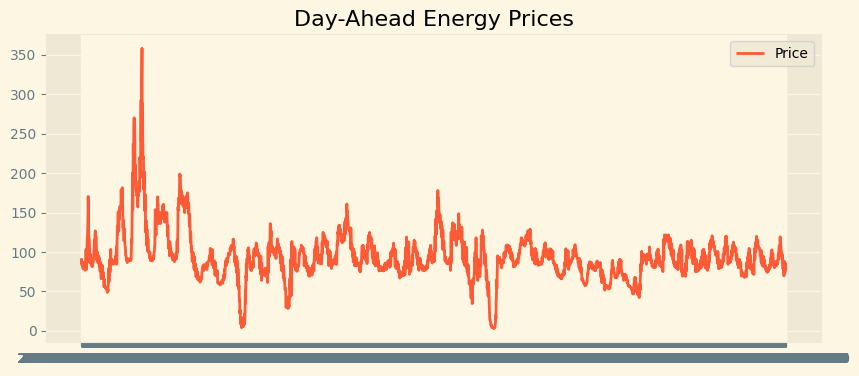

In [16]:
plot_ts(ts, title='Day-Ahead Energy Prices', legend=['Price'])

In [18]:
def _weights(df,dist,alpha=0.6):
    """Function generates the weights for computing the averages

    Args:
        df (pd.DataFrame): The Data the list weights are generated (number of weight = length of data)
        dist (string): The distribution of weights. Possibilities are ["unif","triang","exp"] for uniform, triangular and exponential distributions.
        alpha (float, optional): Exponential smoothing factor in case the "exp" dist is used. Must be between 0 and 1.   Defaults to 0.6.

    Returns:
        [np.array]: [list of weights]
    """
    if dist=="unif":
        weights=np.array([1]*len(df))  #1 1 1 1
    
    if dist=="triang":
        weights=np.arange(1,len(df)+1) #1 2 3 4 

    if dist=="exp":
        weights=np.flip(np.array([alpha*(1-alpha)**i for i in range(len(df))]))
    
    weights=weights/np.sum(weights)
    return weights    

def _mean_unif(df):
    weights=_weights(df,"unif")
    return np.sum(np.array(df)*weights)

def _mean_triang(df):
    weights=_weights(df,"triang")
    return np.sum(np.array(df)*weights)

def _mean_exp(df,exp_alpha):
    weights=_weights(df,"exp",exp_alpha)
    return float(np.sum(np.array(df).ravel()*weights))



In [19]:
def _rmse(y_true,y_pred):
    return(np.sqrt(np.square(y_true - y_pred).mean()))

In [32]:
def mean_unif_window(x):
    return _mean_unif(x.to_frame())

def mean_triang_window(x):
    return _mean_triang(x.to_frame())

def mean_exp_window(x, alpha=0.6):
    return _mean_exp(x.to_frame(), exp_alpha=alpha)


In [33]:
window = 24

In [40]:
ts = ts.to_frame(name="Day-ahead Price (EUR/MWh)")

In [41]:
ts["ma_unif"] = (
    ts["Day-ahead Price (EUR/MWh)"]
    .rolling(window=window, min_periods=window)
    .apply(mean_unif_window, raw=False)
)

In [42]:
ts["ma_triang"] = (
    ts["Day-ahead Price (EUR/MWh)"]
    .rolling(window=window, min_periods=window)
    .apply(mean_triang_window, raw=False)
)

In [43]:
alpha = 0.6

ts["ma_exp"] = (
    ts["Day-ahead Price (EUR/MWh)"]
    .rolling(window=window, min_periods=window)
    .apply(lambda x: mean_exp_window(x, alpha), raw=False)
)

In [44]:
ts["detrended_unif"]   = ts["Day-ahead Price (EUR/MWh)"] - ts["ma_unif"]
ts["detrended_triang"] = ts["Day-ahead Price (EUR/MWh)"] - ts["ma_triang"]
ts["detrended_exp"]    = ts["Day-ahead Price (EUR/MWh)"] - ts["ma_exp"]

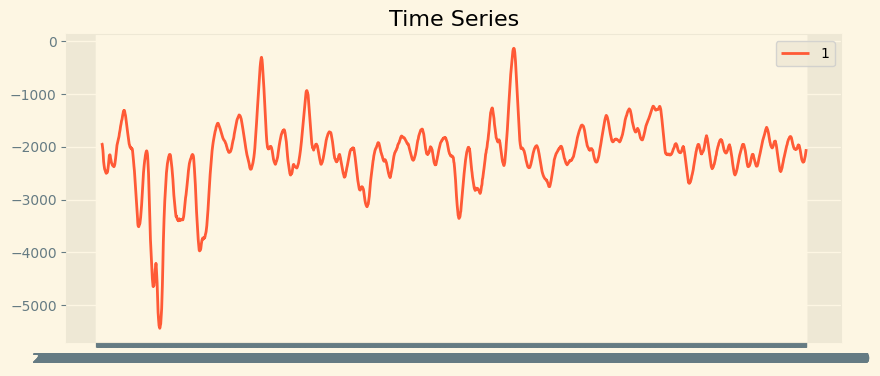

In [53]:
plot_ts(ts = ts["detrended_triang"], ts_add = None, title ='Time Series', legend=['1'])

Text(0, 0.5, 'Price (EUR/MWh)')

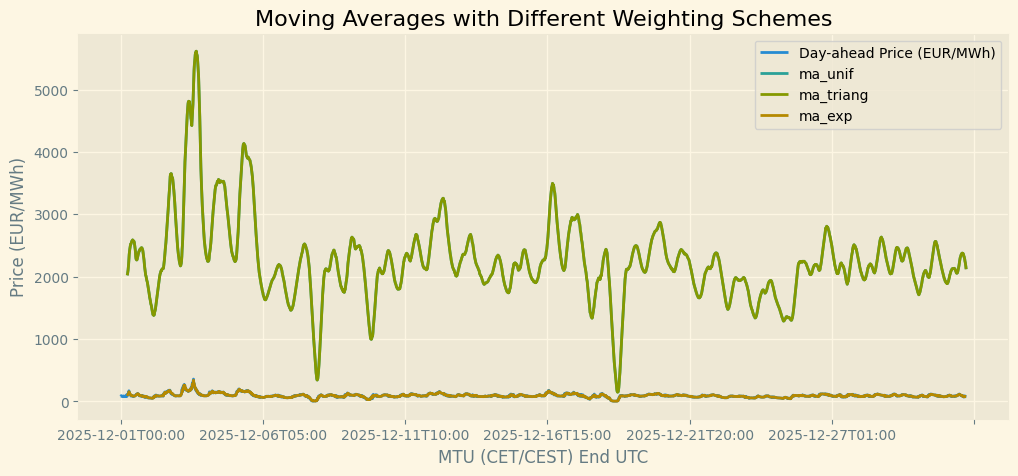

In [49]:
ts[[
    "Day-ahead Price (EUR/MWh)",
    "ma_unif",
    "ma_triang",
    "ma_exp"
]].plot(figsize=(12,5))
plt.title('Moving Averages with Different Weighting Schemes')
plt.ylabel('Price (EUR/MWh)')